In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/readme.txt
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/3_MR_s4.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/12_MR_s3.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/18_MR_s2.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/3_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/9_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/16_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/9_MR_s3.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/9_MR_s5.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/17_MR_s3.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/15_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/

In [2]:
# %% 1) Setup and Dependencies
try:
    import pytorch_fid
    import lpips
    import pydicom
    import torchmetrics
    import cv2
except Exception:
    !pip install --quiet pytorch-fid lpips pydicom torchmetrics opencv-python-headless

In [3]:
# %% 2) Imports & device
import os, glob, random, time, csv
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import cv2 # Added for Grad-CAM visualization utility

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as T
from torchvision.utils import save_image, make_grid
from skimage.metrics import mean_squared_error, normalized_root_mse
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# FID & LPIPS
from pytorch_fid.fid_score import calculate_fid_given_paths
import lpips
import pydicom

2025-10-19 06:58:25.774800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760857105.797996     181 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760857105.804939     181 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Define device and initialize LPIPS metrics globally
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_lpips = lpips.LPIPS(net='alex').to(device)

def calculate_mse_rmse(img1, img2):
    """Calculates MSE and RMSE for normalized torch tensors in [-1, 1]."""
    # Convert from torch tensor [-1, 1] to numpy [0, 1]
    img1_np = ((img1.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2).mean(axis=2)
    img2_np = ((img2.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2).mean(axis=2)
    
    mse = mean_squared_error(img1_np, img2_np)
    rmse = np.sqrt(mse)
    return mse, rmse

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [5]:
# Average meter class for logging
class AverageMeter:
    def __init__(self): self.reset()
    def reset(self): self.val=self.sum=self.count=self.avg=0.0
    def update(self, val, n=1):
        self.val=float(val); self.sum+=float(val)*n; self.count+=n; self.avg=self.sum/self.count

In [6]:
# Reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

print('Device:', device)
DATA_ROOT = '/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset'
IMAGE_SIZE = 256
BATCH_SIZE = 4
NUM_WORKERS = 2
N_EPOCHS = 100
LR = 2e-4
BETA1, BETA2 = 0.5, 0.999
POOL_SIZE = 50
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 5.0
SAVE_EVERY = 5

OUT_DIR = '/kaggle/working/cyclegan_outputs'
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'checkpoints'), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'samples'), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'plots'), exist_ok=True) 

Device: cuda


In [7]:
# dataset folders
MR_FOLDER = os.path.join(DATA_ROOT, 'MR', 'image_MR')
CT_FOLDER = os.path.join(DATA_ROOT, 'CT', 'image_CT')
print('MR_FOLDER =', MR_FOLDER)
print('CT_FOLDER =', CT_FOLDER)
# sanity checks
assert os.path.isdir(MR_FOLDER), f"MR folder not found: {MR_FOLDER}"
assert os.path.isdir(CT_FOLDER), f"CT folder not found: {CT_FOLDER}"

writer = SummaryWriter(log_dir=os.path.join(OUT_DIR, 'logs'))

MR_FOLDER = /kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR
CT_FOLDER = /kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/CT/image_CT


In [8]:
# metrics CSV init (UPDATED: Removed 'ms_ssim' column)
metrics_csv = os.path.join(OUT_DIR, 'metrics.csv')
with open(metrics_csv, 'w', newline='') as f:
    writer_csv = csv.writer(f)
    writer_csv.writerow(['epoch','iteration','loss_G','loss_D_A','loss_D_B',
                         'loss_id_A','loss_id_B','loss_gan_A2B','loss_gan_B2A',
                         'loss_cycle_A','loss_cycle_B','lr','fid','lpips','psnr','ssim',
                         'rmse', 'mse']) 

In [9]:
# DICOM helpers and Dataset
def dcm_to_pil(dcm_path):
    dcm = pydicom.dcmread(dcm_path)
    arr = dcm.pixel_array.astype(np.float32)
    if np.max(arr)==np.min(arr): arr=np.zeros_like(arr)
    else: arr=(arr-np.min(arr))/(np.max(arr)-np.min(arr))
    arr=(arr*255.0).astype(np.uint8)
    if arr.ndim==2: arr=np.stack([arr,arr,arr],axis=-1)
    return Image.fromarray(arr)

class UnpairedDICOMDataset(Dataset):
    def __init__(self, dir_A, dir_B, transform=None):
        self.A_paths=sorted([os.path.join(dir_A,f) for f in os.listdir(dir_A) if f.lower().endswith('.dcm')])
        self.B_paths=sorted([os.path.join(dir_B,f) for f in os.listdir(dir_B) if f.lower().endswith('.dcm')])
        if len(self.A_paths)==0: raise RuntimeError(f'No DICOM in {dir_A}')
        if len(self.B_paths)==0: raise RuntimeError(f'No DICOM in {dir_B}')
        self.transform=transform
    def __len__(self): return max(len(self.A_paths),len(self.B_paths))
    def __getitem__(self,idx):
        A_path=self.A_paths[idx%len(self.A_paths)]
        B_path=random.choice(self.B_paths)
        A_img,B_img=dcm_to_pil(A_path),dcm_to_pil(B_path)
        if self.transform: A,B=self.transform(A_img),self.transform(B_img)
        else: A,B=T.ToTensor()(A_img),T.ToTensor()(B_img)
        return {'A':A,'B':B,'A_paths':A_path,'B_paths':B_path}
transform=T.Compose([
    T.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
dataset=UnpairedDICOMDataset(MR_FOLDER,CT_FOLDER,transform=transform)
dataloader=DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,pin_memory=True)
print('Dataset size =',len(dataset))

Dataset size = 90


In [10]:
# %% 6) Models (same as before: ResNet generator and PatchGAN discriminator)
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        block = []
        block += [nn.ReflectionPad2d(1), nn.Conv2d(dim, dim, kernel_size=3, bias=False), nn.InstanceNorm2d(dim), nn.ReLU(True)]
        block += [nn.ReflectionPad2d(1), nn.Conv2d(dim, dim, kernel_size=3, bias=False), nn.InstanceNorm2d(dim)]
        self.block = nn.Sequential(*block)
    def forward(self, x): return x + self.block(x)


class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=6):
        super().__init__()
        model = []
        model += [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, bias=False), nn.InstanceNorm2d(ngf), nn.ReLU(True)]
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=False),
                      nn.InstanceNorm2d(ngf * mult * 2), nn.ReLU(True)]
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult)]
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                      nn.InstanceNorm2d(int(ngf * mult / 2)), nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3), nn.Conv2d(ngf, output_nc, kernel_size=7), nn.Tanh()]
        self.model = nn.Sequential(*model)
    def forward(self, x): return self.model(x)


class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super().__init__()
        kw = 4; padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult; nf_mult = min(2 ** n, 8)
            sequence += [nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                         nn.InstanceNorm2d(ndf * nf_mult), nn.LeakyReLU(0.2, True)]
        nf_mult_prev = nf_mult; nf_mult = min(2 ** n_layers, 8)
        sequence += [nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
                     nn.InstanceNorm2d(ndf * nf_mult), nn.LeakyReLU(0.2, True)]
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]
        self.model = nn.Sequential(*sequence)
    def forward(self, x): return self.model(x)
def init_weights(net, init_type='normal', init_gain=0.02):
    def init_fun(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal': nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier': nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming': nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            if hasattr(m, 'bias') and m.bias is not None: nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            nn.init.normal_(m.weight.data, 1.0, init_gain); nn.init.constant_(m.bias.data, 0.0)
    net.apply(init_fun)

In [11]:
# 7) Losses, networks, optimizers, schedulers, pools
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

netG_A2B = ResnetGenerator(3, 3, ngf=64, n_blocks=6).to(device)
netG_B2A = ResnetGenerator(3, 3, ngf=64, n_blocks=6).to(device)
netD_A = NLayerDiscriminator(3).to(device)
netD_B = NLayerDiscriminator(3).to(device)

init_weights(netG_A2B); init_weights(netG_B2A); init_weights(netD_A); init_weights(netD_B)

optimizer_G = optim.Adam(list(netG_A2B.parameters()) + list(netG_B2A.parameters()), lr=LR, betas=(BETA1, BETA2))
optimizer_D_A = optim.Adam(netD_A.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_D_B = optim.Adam(netD_B.parameters(), lr=LR, betas=(BETA1, BETA2))
def lambda_rule(epoch):
    start_decay_epoch = int(N_EPOCHS / 2)
    if epoch < start_decay_epoch: return 1.0
    return 1.0 - float(epoch - start_decay_epoch) / (N_EPOCHS - start_decay_epoch + 1)

scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
scheduler_D_A = optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_rule)
scheduler_D_B = optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_rule)
class ImagePool:
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        if pool_size > 0: self.images = []; self.num_imgs = 0
    def query(self, images):
        if self.pool_size == 0: return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs += 1; self.images.append(image.clone()); return_images.append(image)
            else:
                if random.random() > 0.5:
                    idx = random.randint(0, self.pool_size - 1); tmp = self.images[idx].clone()
                    self.images[idx] = image.clone(); return_images.append(tmp)
                else: return_images.append(image)
        return torch.cat(return_images, 0)
fake_A_pool = ImagePool(POOL_SIZE)
fake_B_pool = ImagePool(POOL_SIZE)

def make_target(pred, target_is_real=True):
    return torch.ones_like(pred, device=pred.device) if target_is_real else torch.zeros_like(pred, device=pred.device)

def get_lr(optimizer): return optimizer.param_groups[0]['lr']

print('Starting training with enhanced logging...')
iteration = 0

Starting training with enhanced logging...


In [12]:
# Meters to smooth values for printing
meter_G = AverageMeter(); meter_D_A = AverageMeter(); meter_D_B = AverageMeter()
meter_id_A = AverageMeter(); meter_id_B = AverageMeter()
meter_gan_A2B = AverageMeter(); meter_gan_B2A = AverageMeter()
meter_cycle_A = AverageMeter(); meter_cycle_B = AverageMeter()
for epoch in range(1,N_EPOCHS+1):
    t0=time.time()
    netG_A2B.train(); netG_B2A.train(); netD_A.train(); netD_B.train()
    loop=tqdm(enumerate(dataloader),total=len(dataloader),desc=f"Epoch {epoch}/{N_EPOCHS}")
    for i,data in loop:
        real_A,real_B=data['A'].to(device),data['B'].to(device)

        # ---- Train Generators ----
        optimizer_G.zero_grad()

        # identity
        same_B = netG_A2B(real_B); loss_id_B = criterion_identity(same_B, real_B) * LAMBDA_IDENTITY
        same_A = netG_B2A(real_A); loss_id_A = criterion_identity(same_A, real_A) * LAMBDA_IDENTITY

        # GAN
        fake_B = netG_A2B(real_A); pred_fake_B = netD_B(fake_B); loss_GAN_A2B = criterion_GAN(pred_fake_B, make_target(pred_fake_B, True))
        fake_A = netG_B2A(real_B); pred_fake_A = netD_A(fake_A); loss_GAN_B2A = criterion_GAN(pred_fake_A, make_target(pred_fake_A, True))
        # cycle
        rec_A = netG_B2A(fake_B); loss_cycle_A = criterion_cycle(rec_A, real_A) * LAMBDA_CYCLE
        rec_B = netG_A2B(fake_A); loss_cycle_B = criterion_cycle(rec_B, real_B) * LAMBDA_CYCLE

        loss_G = loss_id_A + loss_id_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_A + loss_cycle_B
        loss_G.backward(); optimizer_G.step()

        # ---- Train Discriminator A ----
        optimizer_D_A.zero_grad()
        pred_real_A = netD_A(real_A); loss_D_real_A = criterion_GAN(pred_real_A, make_target(pred_real_A, True))
        fake_A_det = fake_A_pool.query(fake_A.detach()); pred_fake_A = netD_A(fake_A_det); loss_D_fake_A = criterion_GAN(pred_fake_A, make_target(pred_fake_A, False))
        loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5; loss_D_A.backward(); optimizer_D_A.step()
        
        # ---- Train Discriminator B ----
        optimizer_D_B.zero_grad()
        pred_real_B = netD_B(real_B); loss_D_real_B = criterion_GAN(pred_real_B, make_target(pred_real_B, True))
        fake_B_det = fake_B_pool.query(fake_B.detach()); pred_fake_B = netD_B(fake_B_det); loss_D_fake_B = criterion_GAN(pred_fake_B, make_target(pred_fake_B, False))
        loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5; loss_D_B.backward(); optimizer_D_B.step()

        # update iteration counters and meters
        iteration += 1
        meter_G.update(loss_G.item()); meter_D_A.update(loss_D_A.item()); meter_D_B.update(loss_D_B.item())
        meter_id_A.update(loss_id_A.item()); meter_id_B.update(loss_id_B.item()); meter_gan_A2B.update(loss_GAN_A2B.item())
        meter_gan_B2A.update(loss_GAN_B2A.item()); meter_cycle_A.update(loss_cycle_A.item()); meter_cycle_B.update(loss_cycle_B.item())

        # TensorBoard per-iteration logging (sample every 50 iters)
        if iteration % 50 == 0:
            writer.add_scalar('Loss/loss_G', meter_G.avg, iteration); writer.add_scalar('Loss/loss_D_A', meter_D_A.avg, iteration)
            writer.add_scalar('Loss/loss_D_B', meter_D_B.avg, iteration); writer.add_scalar('LR/lr_G', get_lr(optimizer_G), iteration)

        if iteration%500==0:
            with torch.no_grad():
                sample=torch.cat([real_A[:2],fake_B[:2],real_B[:2],fake_A[:2]],0); sample_img=(sample+1)/2.0
                grid_img=make_grid(sample_img,nrow=2,padding=2,normalize=False)
                save_image(sample_img,os.path.join(OUT_DIR,'samples',f'iter_{iteration}.png'),nrow=2)
                writer.add_image('Samples/iter',grid_img,iteration)

        # update tqdm display
        loop.set_postfix({'G': f'{meter_G.avg:.4f}', 'D_A': f'{meter_D_A.avg:.4f}', 'D_B': f'{meter_D_B.avg:.4f}'})
        
    # end of epoch: scheduler step
    scheduler_G.step(); scheduler_D_A.step(); scheduler_D_B.step()

    # save checkpoint every SAVE_EVERY epochs
    if epoch % SAVE_EVERY == 0 or epoch == N_EPOCHS:
        ckpt_path = os.path.join(OUT_DIR, 'checkpoints', f'ckpt_epoch_{epoch}.pth')
        torch.save({'epoch': epoch, 'netG_A2B': netG_A2B.state_dict(), 'netG_B2A': netG_B2A.state_dict()}, ckpt_path) # Simplified save
        # Log epoch metrics to CSV (only training losses here)
    with open(metrics_csv, 'a', newline='') as f:
        writer_csv = csv.writer(f)
        # Placeholder update: Removed 'ms_ssim' column placeholder
        writer_csv.writerow([
            epoch, iteration, meter_G.avg, meter_D_A.avg, meter_D_B.avg,
            meter_id_A.avg, meter_id_B.avg, meter_gan_A2B.avg, meter_gan_B2A.avg,
            meter_cycle_A.avg, meter_cycle_B.avg, get_lr(optimizer_G),
            '', '', '', '', '', '' # Removed one placeholder for ms_ssim
        ])

    # print epoch summary
    t1 = time.time()
    print(f"Epoch {epoch} finished in {t1-t0:.1f}s - G: {meter_G.avg:.4f}, D_A: {meter_D_A.avg:.4f}, D_B: {meter_D_B.avg:.4f}")

print('Training finished.')
writer.close()


Epoch 1/100: 100%|██████████| 23/23 [00:46<00:00,  2.01s/it, G=11.9328, D_A=1.5038, D_B=1.7231]

Epoch 1 finished in 46.3s - G: 11.9328, D_A: 1.5038, D_B: 1.7231



Epoch 2/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=7.9034, D_A=0.9912, D_B=1.0886]

Epoch 2 finished in 45.5s - G: 7.9034, D_A: 0.9912, D_B: 1.0886



Epoch 3/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=6.3702, D_A=0.7709, D_B=0.8500]

Epoch 3 finished in 45.6s - G: 6.3702, D_A: 0.7709, D_B: 0.8500



Epoch 4/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=5.5859, D_A=0.6446, D_B=0.7094]

Epoch 4 finished in 45.3s - G: 5.5859, D_A: 0.6446, D_B: 0.7094



Epoch 5/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=5.0813, D_A=0.5650, D_B=0.6219]

Epoch 5 finished in 45.7s - G: 5.0813, D_A: 0.5650, D_B: 0.6219



Epoch 6/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=4.7293, D_A=0.5081, D_B=0.5644]

Epoch 6 finished in 45.7s - G: 4.7293, D_A: 0.5081, D_B: 0.5644



Epoch 7/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=4.5102, D_A=0.4834, D_B=0.5205]

Epoch 7 finished in 45.3s - G: 4.5102, D_A: 0.4834, D_B: 0.5205



Epoch 8/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=4.2856, D_A=0.4487, D_B=0.4793]

Epoch 8 finished in 45.4s - G: 4.2856, D_A: 0.4487, D_B: 0.4793



Epoch 9/100: 100%|██████████| 23/23 [00:45<00:00,  1.99s/it, G=4.1239, D_A=0.4234, D_B=0.4541]

Epoch 9 finished in 45.7s - G: 4.1239, D_A: 0.4234, D_B: 0.4541



Epoch 10/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=3.9923, D_A=0.4074, D_B=0.4360]

Epoch 10 finished in 45.5s - G: 3.9923, D_A: 0.4074, D_B: 0.4360



Epoch 11/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=3.8786, D_A=0.3932, D_B=0.4124]

Epoch 11 finished in 45.3s - G: 3.8786, D_A: 0.3932, D_B: 0.4124



Epoch 12/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=3.8105, D_A=0.3774, D_B=0.3960]

Epoch 12 finished in 45.6s - G: 3.8105, D_A: 0.3774, D_B: 0.3960



Epoch 13/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=3.7362, D_A=0.3656, D_B=0.3805]

Epoch 13 finished in 45.6s - G: 3.7362, D_A: 0.3656, D_B: 0.3805



Epoch 14/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=3.6734, D_A=0.3537, D_B=0.3682]

Epoch 14 finished in 45.4s - G: 3.6734, D_A: 0.3537, D_B: 0.3682



Epoch 15/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=3.6110, D_A=0.3423, D_B=0.3642]

Epoch 15 finished in 45.4s - G: 3.6110, D_A: 0.3423, D_B: 0.3642



Epoch 16/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=3.5441, D_A=0.3352, D_B=0.3556]

Epoch 16 finished in 45.6s - G: 3.5441, D_A: 0.3352, D_B: 0.3556



Epoch 17/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=3.5088, D_A=0.3270, D_B=0.3478]

Epoch 17 finished in 45.7s - G: 3.5088, D_A: 0.3270, D_B: 0.3478



Epoch 18/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=3.4671, D_A=0.3191, D_B=0.3406]

Epoch 18 finished in 45.7s - G: 3.4671, D_A: 0.3191, D_B: 0.3406



Epoch 19/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=3.4270, D_A=0.3136, D_B=0.3344]

Epoch 19 finished in 45.5s - G: 3.4270, D_A: 0.3136, D_B: 0.3344



Epoch 20/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=3.3769, D_A=0.3094, D_B=0.3313]

Epoch 20 finished in 45.4s - G: 3.3769, D_A: 0.3094, D_B: 0.3313



Epoch 21/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=3.3327, D_A=0.3069, D_B=0.3271]

Epoch 21 finished in 45.4s - G: 3.3327, D_A: 0.3069, D_B: 0.3271



Epoch 22/100: 100%|██████████| 23/23 [00:45<00:00,  2.00s/it, G=3.2871, D_A=0.3047, D_B=0.3243]

Epoch 22 finished in 46.0s - G: 3.2871, D_A: 0.3047, D_B: 0.3243



Epoch 23/100: 100%|██████████| 23/23 [00:45<00:00,  1.99s/it, G=3.2485, D_A=0.3050, D_B=0.3230]

Epoch 23 finished in 45.7s - G: 3.2485, D_A: 0.3050, D_B: 0.3230



Epoch 24/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=3.1998, D_A=0.3023, D_B=0.3189]

Epoch 24 finished in 45.6s - G: 3.1998, D_A: 0.3023, D_B: 0.3189



Epoch 25/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=3.1603, D_A=0.3003, D_B=0.3168]

Epoch 25 finished in 45.7s - G: 3.1603, D_A: 0.3003, D_B: 0.3168



Epoch 26/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=3.1315, D_A=0.2969, D_B=0.3139]

Epoch 26 finished in 45.6s - G: 3.1315, D_A: 0.2969, D_B: 0.3139



Epoch 27/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=3.1038, D_A=0.2937, D_B=0.3104]

Epoch 27 finished in 45.3s - G: 3.1038, D_A: 0.2937, D_B: 0.3104



Epoch 28/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=3.0829, D_A=0.2905, D_B=0.3102]

Epoch 28 finished in 45.3s - G: 3.0829, D_A: 0.2905, D_B: 0.3102



Epoch 29/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=3.0570, D_A=0.2905, D_B=0.3082]

Epoch 29 finished in 45.4s - G: 3.0570, D_A: 0.2905, D_B: 0.3082



Epoch 30/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=3.0331, D_A=0.2880, D_B=0.3050]

Epoch 30 finished in 45.7s - G: 3.0331, D_A: 0.2880, D_B: 0.3050



Epoch 31/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=3.0107, D_A=0.2851, D_B=0.3031]

Epoch 31 finished in 45.6s - G: 3.0107, D_A: 0.2851, D_B: 0.3031



Epoch 32/100: 100%|██████████| 23/23 [00:45<00:00,  1.99s/it, G=2.9866, D_A=0.2842, D_B=0.3024]

Epoch 32 finished in 45.7s - G: 2.9866, D_A: 0.2842, D_B: 0.3024



Epoch 33/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.9599, D_A=0.2828, D_B=0.3024]

Epoch 33 finished in 45.6s - G: 2.9599, D_A: 0.2828, D_B: 0.3024



Epoch 34/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.9318, D_A=0.2826, D_B=0.3007]

Epoch 34 finished in 45.6s - G: 2.9318, D_A: 0.2826, D_B: 0.3007



Epoch 35/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.9023, D_A=0.2814, D_B=0.2988]

Epoch 35 finished in 45.6s - G: 2.9023, D_A: 0.2814, D_B: 0.2988



Epoch 36/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.8768, D_A=0.2811, D_B=0.2968]

Epoch 36 finished in 45.5s - G: 2.8768, D_A: 0.2811, D_B: 0.2968



Epoch 37/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.8615, D_A=0.2809, D_B=0.2949]

Epoch 37 finished in 45.4s - G: 2.8615, D_A: 0.2809, D_B: 0.2949



Epoch 38/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.8447, D_A=0.2792, D_B=0.2937]

Epoch 38 finished in 45.4s - G: 2.8447, D_A: 0.2792, D_B: 0.2937



Epoch 39/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.8237, D_A=0.2788, D_B=0.2920]

Epoch 39 finished in 45.5s - G: 2.8237, D_A: 0.2788, D_B: 0.2920



Epoch 40/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.8045, D_A=0.2776, D_B=0.2907]

Epoch 40 finished in 45.7s - G: 2.8045, D_A: 0.2776, D_B: 0.2907



Epoch 41/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.8055, D_A=0.2761, D_B=0.3049]

Epoch 41 finished in 45.5s - G: 2.8055, D_A: 0.2761, D_B: 0.3049



Epoch 42/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.7847, D_A=0.2756, D_B=0.3033]

Epoch 42 finished in 45.4s - G: 2.7847, D_A: 0.2756, D_B: 0.3033



Epoch 43/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.7617, D_A=0.2750, D_B=0.3018]

Epoch 43 finished in 45.4s - G: 2.7617, D_A: 0.2750, D_B: 0.3018



Epoch 44/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.7456, D_A=0.2744, D_B=0.3002]

Epoch 44 finished in 45.6s - G: 2.7456, D_A: 0.2744, D_B: 0.3002



Epoch 45/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.7288, D_A=0.2734, D_B=0.2985]

Epoch 45 finished in 45.7s - G: 2.7288, D_A: 0.2734, D_B: 0.2985



Epoch 46/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.7144, D_A=0.2731, D_B=0.2966]

Epoch 46 finished in 45.7s - G: 2.7144, D_A: 0.2731, D_B: 0.2966



Epoch 47/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.6996, D_A=0.2717, D_B=0.2948]

Epoch 47 finished in 45.6s - G: 2.6996, D_A: 0.2717, D_B: 0.2948



Epoch 48/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.6852, D_A=0.2719, D_B=0.2933]

Epoch 48 finished in 45.6s - G: 2.6852, D_A: 0.2719, D_B: 0.2933



Epoch 49/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.6687, D_A=0.2716, D_B=0.2919]

Epoch 49 finished in 45.7s - G: 2.6687, D_A: 0.2716, D_B: 0.2919



Epoch 50/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.6579, D_A=0.2701, D_B=0.2903]

Epoch 50 finished in 45.7s - G: 2.6579, D_A: 0.2701, D_B: 0.2903



Epoch 51/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.6454, D_A=0.2689, D_B=0.2891]

Epoch 51 finished in 45.5s - G: 2.6454, D_A: 0.2689, D_B: 0.2891



Epoch 52/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.6332, D_A=0.2683, D_B=0.2879]

Epoch 52 finished in 45.5s - G: 2.6332, D_A: 0.2683, D_B: 0.2879



Epoch 53/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.6243, D_A=0.2669, D_B=0.2864]

Epoch 53 finished in 45.3s - G: 2.6243, D_A: 0.2669, D_B: 0.2864



Epoch 54/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.6173, D_A=0.2662, D_B=0.2852]

Epoch 54 finished in 45.5s - G: 2.6173, D_A: 0.2662, D_B: 0.2852



Epoch 55/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.6116, D_A=0.2644, D_B=0.2834]

Epoch 55 finished in 45.7s - G: 2.6116, D_A: 0.2644, D_B: 0.2834



Epoch 56/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.6014, D_A=0.2631, D_B=0.2824]

Epoch 56 finished in 45.7s - G: 2.6014, D_A: 0.2631, D_B: 0.2824



Epoch 57/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.5943, D_A=0.2626, D_B=0.2811]

Epoch 57 finished in 45.5s - G: 2.5943, D_A: 0.2626, D_B: 0.2811



Epoch 58/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.5871, D_A=0.2610, D_B=0.2800]

Epoch 58 finished in 45.6s - G: 2.5871, D_A: 0.2610, D_B: 0.2800



Epoch 59/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.5768, D_A=0.2603, D_B=0.2789]

Epoch 59 finished in 45.6s - G: 2.5768, D_A: 0.2603, D_B: 0.2789



Epoch 60/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.5658, D_A=0.2590, D_B=0.2779]

Epoch 60 finished in 45.5s - G: 2.5658, D_A: 0.2590, D_B: 0.2779



Epoch 61/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.5573, D_A=0.2584, D_B=0.2769]

Epoch 61 finished in 45.4s - G: 2.5573, D_A: 0.2584, D_B: 0.2769



Epoch 62/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.5472, D_A=0.2574, D_B=0.2759]

Epoch 62 finished in 45.5s - G: 2.5472, D_A: 0.2574, D_B: 0.2759



Epoch 63/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.5402, D_A=0.2560, D_B=0.2753]

Epoch 63 finished in 45.4s - G: 2.5402, D_A: 0.2560, D_B: 0.2753



Epoch 64/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.5295, D_A=0.2552, D_B=0.2744]

Epoch 64 finished in 45.4s - G: 2.5295, D_A: 0.2552, D_B: 0.2744



Epoch 65/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.5193, D_A=0.2544, D_B=0.2735]

Epoch 65 finished in 45.7s - G: 2.5193, D_A: 0.2544, D_B: 0.2735



Epoch 66/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.5088, D_A=0.2535, D_B=0.2726]

Epoch 66 finished in 45.7s - G: 2.5088, D_A: 0.2535, D_B: 0.2726



Epoch 67/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.4974, D_A=0.2528, D_B=0.2720]

Epoch 67 finished in 45.4s - G: 2.4974, D_A: 0.2528, D_B: 0.2720



Epoch 68/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.4869, D_A=0.2520, D_B=0.2710]

Epoch 68 finished in 45.5s - G: 2.4869, D_A: 0.2520, D_B: 0.2710



Epoch 69/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.4769, D_A=0.2512, D_B=0.2703]

Epoch 69 finished in 45.7s - G: 2.4769, D_A: 0.2512, D_B: 0.2703



Epoch 70/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.4686, D_A=0.2505, D_B=0.2696]

Epoch 70 finished in 45.7s - G: 2.4686, D_A: 0.2505, D_B: 0.2696



Epoch 71/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.4627, D_A=0.2496, D_B=0.2686]

Epoch 71 finished in 45.6s - G: 2.4627, D_A: 0.2496, D_B: 0.2686



Epoch 72/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.4537, D_A=0.2485, D_B=0.2679]

Epoch 72 finished in 45.3s - G: 2.4537, D_A: 0.2485, D_B: 0.2679



Epoch 73/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.4444, D_A=0.2475, D_B=0.2671]

Epoch 73 finished in 45.5s - G: 2.4444, D_A: 0.2475, D_B: 0.2671



Epoch 74/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.4356, D_A=0.2469, D_B=0.2664]

Epoch 74 finished in 45.6s - G: 2.4356, D_A: 0.2469, D_B: 0.2664



Epoch 75/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.4253, D_A=0.2465, D_B=0.2657]

Epoch 75 finished in 45.7s - G: 2.4253, D_A: 0.2465, D_B: 0.2657



Epoch 76/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.4160, D_A=0.2455, D_B=0.2651]

Epoch 76 finished in 45.7s - G: 2.4160, D_A: 0.2455, D_B: 0.2651



Epoch 77/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.4085, D_A=0.2443, D_B=0.2645]

Epoch 77 finished in 45.5s - G: 2.4085, D_A: 0.2443, D_B: 0.2645



Epoch 78/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.3988, D_A=0.2438, D_B=0.2639]

Epoch 78 finished in 45.4s - G: 2.3988, D_A: 0.2438, D_B: 0.2639



Epoch 79/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.3899, D_A=0.2433, D_B=0.2632]

Epoch 79 finished in 45.5s - G: 2.3899, D_A: 0.2433, D_B: 0.2632



Epoch 80/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.3815, D_A=0.2421, D_B=0.2625]

Epoch 80 finished in 45.6s - G: 2.3815, D_A: 0.2421, D_B: 0.2625



Epoch 81/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.3763, D_A=0.2410, D_B=0.2618]

Epoch 81 finished in 45.6s - G: 2.3763, D_A: 0.2410, D_B: 0.2618



Epoch 82/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.3705, D_A=0.2397, D_B=0.2611]

Epoch 82 finished in 45.6s - G: 2.3705, D_A: 0.2397, D_B: 0.2611



Epoch 83/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.3629, D_A=0.2387, D_B=0.2605]

Epoch 83 finished in 45.5s - G: 2.3629, D_A: 0.2387, D_B: 0.2605



Epoch 84/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.3553, D_A=0.2378, D_B=0.2599]

Epoch 84 finished in 45.3s - G: 2.3553, D_A: 0.2378, D_B: 0.2599



Epoch 85/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.3472, D_A=0.2371, D_B=0.2592]

Epoch 85 finished in 45.5s - G: 2.3472, D_A: 0.2371, D_B: 0.2592



Epoch 86/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.3391, D_A=0.2365, D_B=0.2586]

Epoch 86 finished in 45.5s - G: 2.3391, D_A: 0.2365, D_B: 0.2586



Epoch 87/100: 100%|██████████| 23/23 [00:45<00:00,  2.00s/it, G=2.3313, D_A=0.2356, D_B=0.2582]

Epoch 87 finished in 46.0s - G: 2.3313, D_A: 0.2356, D_B: 0.2582



Epoch 88/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.3241, D_A=0.2345, D_B=0.2577]

Epoch 88 finished in 45.6s - G: 2.3241, D_A: 0.2345, D_B: 0.2577



Epoch 89/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.3166, D_A=0.2335, D_B=0.2573]

Epoch 89 finished in 45.7s - G: 2.3166, D_A: 0.2335, D_B: 0.2573



Epoch 90/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.3093, D_A=0.2325, D_B=0.2566]

Epoch 90 finished in 45.7s - G: 2.3093, D_A: 0.2325, D_B: 0.2566



Epoch 91/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.3016, D_A=0.2316, D_B=0.2560]

Epoch 91 finished in 45.7s - G: 2.3016, D_A: 0.2316, D_B: 0.2560



Epoch 92/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.2945, D_A=0.2308, D_B=0.2554]

Epoch 92 finished in 45.4s - G: 2.2945, D_A: 0.2308, D_B: 0.2554



Epoch 93/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.2874, D_A=0.2299, D_B=0.2548]

Epoch 93 finished in 45.5s - G: 2.2874, D_A: 0.2299, D_B: 0.2548



Epoch 94/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.2803, D_A=0.2290, D_B=0.2543]

Epoch 94 finished in 45.6s - G: 2.2803, D_A: 0.2290, D_B: 0.2543



Epoch 95/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.2732, D_A=0.2281, D_B=0.2538]

Epoch 95 finished in 45.5s - G: 2.2732, D_A: 0.2281, D_B: 0.2538



Epoch 96/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.2658, D_A=0.2272, D_B=0.2533]

Epoch 96 finished in 45.4s - G: 2.2658, D_A: 0.2272, D_B: 0.2533



Epoch 97/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.2587, D_A=0.2264, D_B=0.2528]

Epoch 97 finished in 45.6s - G: 2.2587, D_A: 0.2264, D_B: 0.2528



Epoch 98/100: 100%|██████████| 23/23 [00:45<00:00,  1.98s/it, G=2.2515, D_A=0.2257, D_B=0.2522]

Epoch 98 finished in 45.6s - G: 2.2515, D_A: 0.2257, D_B: 0.2522



Epoch 99/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.2445, D_A=0.2250, D_B=0.2517]

Epoch 99 finished in 45.5s - G: 2.2445, D_A: 0.2250, D_B: 0.2517



Epoch 100/100: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it, G=2.2376, D_A=0.2244, D_B=0.2513]

Epoch 100 finished in 45.5s - G: 2.2376, D_A: 0.2244, D_B: 0.2513
Training finished.


In [13]:
# %% 9) Inference helper (handles .dcm input)
def generate_folder_from_dcm(netG, source_dcm_folder, out_folder, transform=None):
    os.makedirs(out_folder, exist_ok=True)
    dcm_paths = sorted([p for p in glob.glob(os.path.join(source_dcm_folder, '*')) if p.lower().endswith('.dcm')])
    for p in tqdm(dcm_paths, desc=f'Generating -> {out_folder}'):
        img = dcm_to_pil(p)
        if transform is not None: x = transform(img).unsqueeze(0).to(device)
        else: x = T.ToTensor()(T.Resize((IMAGE_SIZE, IMAGE_SIZE))(img)).unsqueeze(0).to(device) * 2.0 - 1.0
        with torch.no_grad(): y = netG(x)
        save_image((y + 1) / 2.0, os.path.join(out_folder, os.path.basename(p).replace('.dcm', '.png')))

generated_A2B_folder = os.path.join(OUT_DIR, 'generated_A2B')
generate_folder_from_dcm(netG_A2B, MR_FOLDER, generated_A2B_folder, transform=transform)

Generating -> /kaggle/working/cyclegan_outputs/generated_A2B: 100%|██████████| 90/90 [00:03<00:00, 25.31it/s]


In [15]:
# %% 10) Evaluation: Comprehensive Metrics Calculation (FID, LPIPS, PSNR, SSIM, RMSE, MSE)
real_CT_folder = CT_FOLDER
tmp_real_ct = os.path.join(OUT_DIR, 'tmp_real_CT')

def calculate_metrics_A2B(generated_folder, real_dcm_folder, tmp_real_folder, n_eval=200):
    
    # 1. Prepare Real Images (convert DCM to PNG)
    os.makedirs(tmp_real_folder, exist_ok=True)
    real_paths_dcm = sorted([p for p in glob.glob(os.path.join(real_dcm_folder, '*')) if p.lower().endswith('.dcm')])
    for i, p in enumerate(tqdm(real_paths_dcm, desc='Converting real DICOMs to PNG')):
        im = dcm_to_pil(p); im.resize((IMAGE_SIZE, IMAGE_SIZE)).save(os.path.join(tmp_real_folder, f'ct_{i:05d}.png'))
        
    fake_paths = sorted([p for p in glob.glob(os.path.join(generated_folder, '*')) if p.lower().endswith(('.png', '.jpg', '.jpeg'))])
    real_paths = sorted([p for p in glob.glob(os.path.join(tmp_real_folder, '*')) if p.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    # UPDATED: Removed 'ms_ssim' from metrics dictionary
    metrics = {'fid': 'N/A', 'lpips': 'N/A', 'psnr': 'N/A', 'ssim': 'N/A', 'rmse': 'N/A', 'mse': 'N/A'}

    # 2. FID
    print('Computing FID...')
    try:
        fid_val = calculate_fid_given_paths([tmp_real_folder, generated_folder], batch_size=16, device=str(device), dims=2048)
        metrics['fid'] = fid_val; print(f'FID: {fid_val:.4f}')
    except Exception as e:
        print(f'FID failed: {e}')

    # 3. IQA Metrics (Approximate for Unpaired Data)
    n_eval = min(len(fake_paths), len(real_paths), n_eval)
    if n_eval > 0:
        print(f'Computing IQA metrics on {n_eval} samples (approx.)...')
        # UPDATED: Removed s_ms_ssim accumulator
        s_lpips = s_psnr = s_ssim = s_rmse = s_mse = 0.0
        
        for i in tqdm(range(n_eval), desc='IQA Metrics'):
            # Load & convert to tensor [-1, 1]
            f_tensor = T.ToTensor()(T.Resize((IMAGE_SIZE, IMAGE_SIZE))(Image.open(fake_paths[i]).convert('RGB'))).unsqueeze(0).to(device) * 2.0 - 1.0
            r_tensor = T.ToTensor()(T.Resize((IMAGE_SIZE, IMAGE_SIZE))(Image.open(real_paths[i % len(real_paths)]).convert('RGB'))).unsqueeze(0).to(device) * 2.0 - 1.0 
            
            with torch.no_grad(): d_lpips = loss_lpips(f_tensor, r_tensor); s_lpips += d_lpips.item()
            
            f_tensor_01 = (f_tensor + 1.0) / 2.0; r_tensor_01 = (r_tensor + 1.0) / 2.0
            f_np = f_tensor_01.squeeze().permute(1, 2, 0).cpu().numpy()
            r_np = r_tensor_01.squeeze().permute(1, 2, 0).cpu().numpy()
            
            s_ssim += ssim(r_np, f_np, data_range=1.0, channel_axis=-1, multichannel=True)
            s_psnr += psnr(r_np, f_np, data_range=1.0)
            d_mse, d_rmse = calculate_mse_rmse(f_tensor, r_tensor)
            s_mse += d_mse; s_rmse += d_rmse
            
        metrics['lpips'] = s_lpips / n_eval; metrics['psnr'] = s_psnr / n_eval; metrics['ssim'] = s_ssim / n_eval
        metrics['rmse'] = s_rmse / n_eval; metrics['mse'] = s_mse / n_eval
        
        print(f"LPIPS: {metrics['lpips']:.4f}")
        print(f"PSNR: {metrics['psnr']:.4f}")
        print(f"SSIM: {metrics['ssim']:.4f}")
        print(f"RMSE: {metrics['rmse']:.4f}")
        print(f"MSE: {metrics['mse']:.4e}")
        
    # 4. Log to main 'metrics.csv'
    df = pd.read_csv(metrics_csv)
    if not df.empty:
        last_epoch = df['epoch'].iloc[-1]
        # UPDATED: Removed 'ms_ssim' column from df.loc update
        df.loc[df['epoch'] == last_epoch, ['fid', 'lpips', 'psnr', 'ssim', 'rmse', 'mse']] = [
            metrics['fid'], metrics['lpips'], metrics['psnr'], metrics['ssim'], metrics['rmse'], metrics['mse']
        ]
        df.to_csv(metrics_csv, index=False)
        print(f"Final metrics appended to training log in {metrics_csv}")
    
    return metrics

final_metrics = calculate_metrics_A2B(generated_A2B_folder, real_CT_folder, tmp_real_ct, n_eval=min(len(os.listdir(generated_A2B_folder)), 200))
print('Done. Check', OUT_DIR, 'for checkpoints, samples, generated images, and metrics CSVs.')

Converting real DICOMs to PNG: 100%|██████████| 88/88 [00:01<00:00, 86.37it/s]


Computing FID...


100%|██████████| 6/6 [00:00<00:00, 10.92it/s]


FID: 192.6995
Computing IQA metrics on 88 samples (approx.)...


IQA Metrics: 100%|██████████| 88/88 [00:01<00:00, 44.60it/s]

LPIPS: 0.3554
PSNR: 11.1030
SSIM: 0.5105
RMSE: 0.2814
MSE: 8.0809e-02
Final metrics appended to training log in /kaggle/working/cyclegan_outputs/metrics.csv
Done. Check /kaggle/working/cyclegan_outputs for checkpoints, samples, generated images, and metrics CSVs.


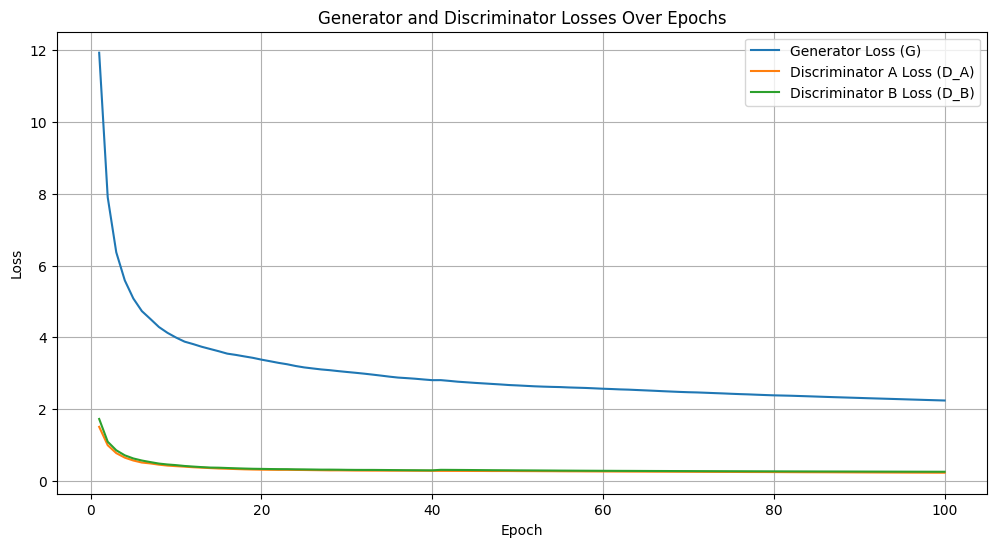

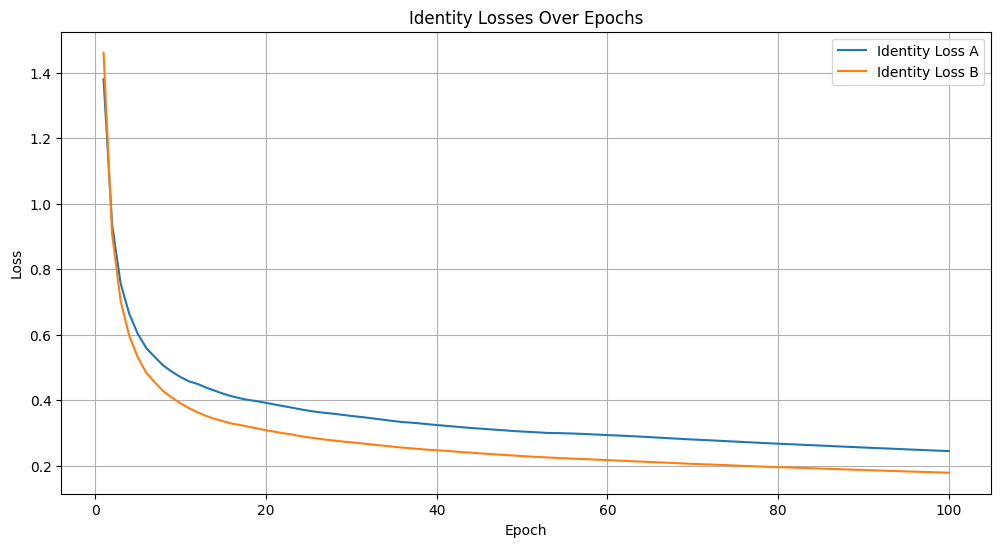

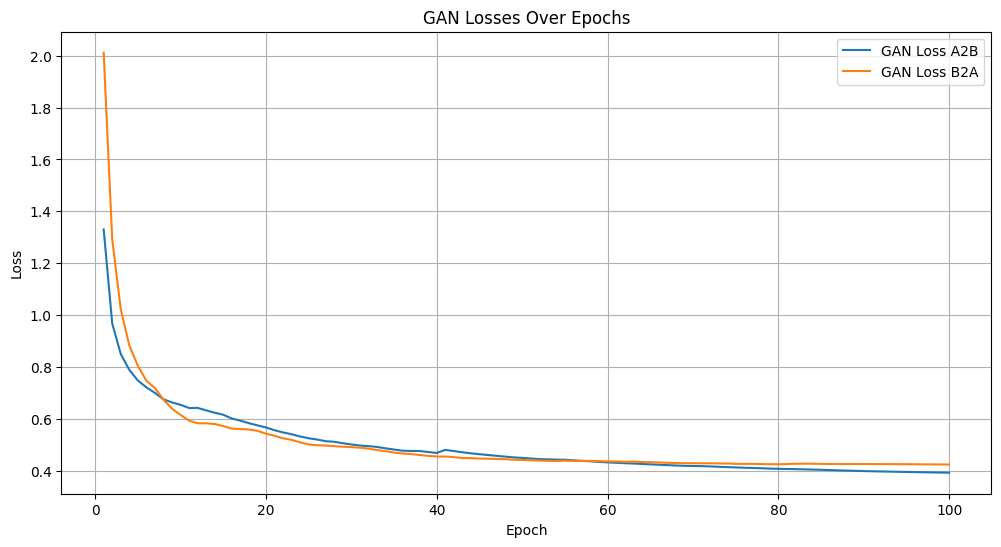

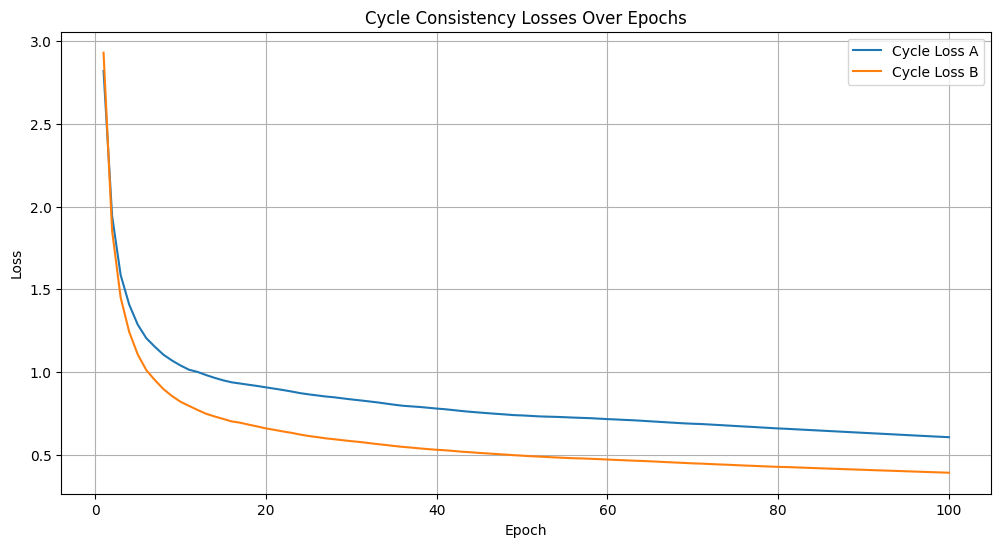

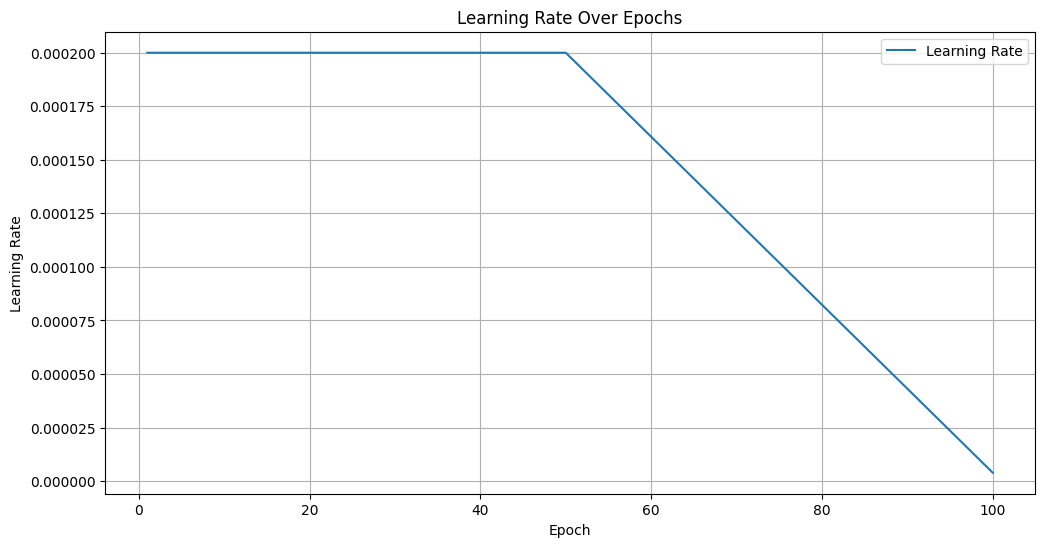

In [16]:
# %% 13) Visualization & Final Output

# Load updated metrics (assuming metrics_csv contains final IQA results on the last row)
metrics_df = pd.read_csv(metrics_csv)

# ------------------------------------------------------------------
# --- Loss Plots ---
# ------------------------------------------------------------------
os.makedirs(os.path.join(OUT_DIR, 'plots'), exist_ok=True)

# 1. Generator and Discriminator Losses
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_G'], label='Generator Loss (G)')
plt.plot(metrics_df['epoch'], metrics_df['loss_D_A'], label='Discriminator A Loss (D_A)')
plt.plot(metrics_df['epoch'], metrics_df['loss_D_B'], label='Discriminator B Loss (D_B)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Generator and Discriminator Losses Over Epochs')
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, 'plots', 'generator_discriminator_losses.png'), dpi=150)
plt.show()

# 2. Identity Losses
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_id_A'], label='Identity Loss A')
plt.plot(metrics_df['epoch'], metrics_df['loss_id_B'], label='Identity Loss B')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Identity Losses Over Epochs')
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, 'plots', 'identity_losses.png'), dpi=150)
plt.show()

# 3. GAN Losses
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_gan_A2B'], label='GAN Loss A2B')
plt.plot(metrics_df['epoch'], metrics_df['loss_gan_B2A'], label='GAN Loss B2A')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('GAN Losses Over Epochs')
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, 'plots', 'gan_losses.png'), dpi=150)
plt.show()

# 4. Cycle Losses
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_cycle_A'], label='Cycle Loss A')
plt.plot(metrics_df['epoch'], metrics_df['loss_cycle_B'], label='Cycle Loss B')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Cycle Consistency Losses Over Epochs')
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, 'plots', 'cycle_losses.png'), dpi=150)
plt.show()

# 5. Learning Rate
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['lr'], label='Learning Rate')
plt.xlabel('Epoch'); plt.ylabel('Learning Rate'); plt.title('Learning Rate Over Epochs')
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, 'plots', 'learning_rate.png'), dpi=150)
plt.show()

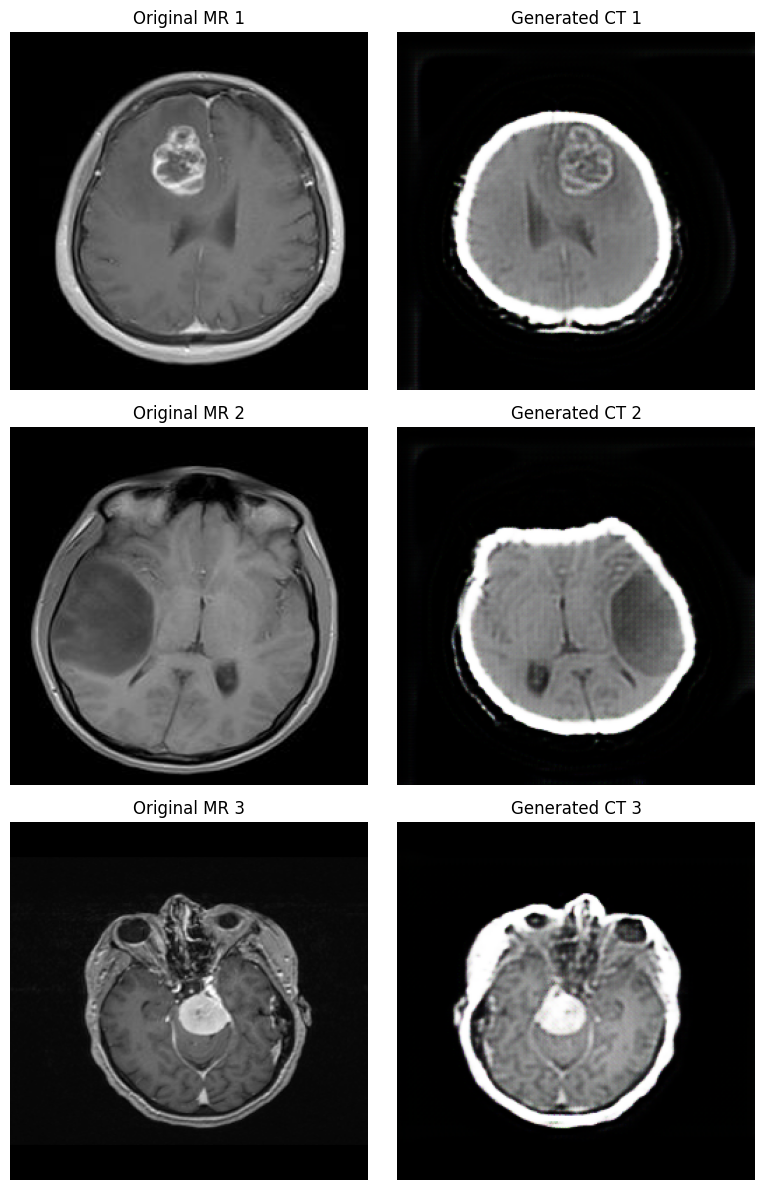

Saved sample pairs to /kaggle/working/cyclegan_outputs/plots/sample_pairs.png


In [17]:
# --- Sample Visualization (Final Output Comparison) 
gen_folder = os.path.join(OUT_DIR, 'generated_A2B')
mr_paths = sorted(glob.glob(os.path.join(MR_FOLDER, '*.dcm')))
n_show = min(3, len(mr_paths))
idxs = [0, len(mr_paths)//2, len(mr_paths)-1][:n_show]
selected = [mr_paths[i] for i in idxs]

fig, axs = plt.subplots(n_show, 2, figsize=(8, 4 * n_show))
for i, mr_p in enumerate(selected):
    mr_img = dcm_to_pil(mr_p).resize((IMAGE_SIZE, IMAGE_SIZE))
    base = os.path.basename(mr_p).replace('.dcm', '.png')
    gen_p = os.path.join(gen_folder, base)
    
    if not os.path.exists(gen_p):
        print(f"Missing generated file for {base}, skipping...")
        continue
    
    gen_img = Image.open(gen_p).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
    ax_left = axs[i, 0] if n_show > 1 else axs[0]
    ax_right = axs[i, 1] if n_show > 1 else axs[1]
    ax_left.imshow(mr_img); ax_left.set_title(f'Original MR {i+1}'); ax_left.axis('off')
    ax_right.imshow(gen_img); ax_right.set_title(f'Generated CT {i+1}'); ax_right.axis('off')

plt.tight_layout()
save_path = os.path.join(OUT_DIR, 'plots', 'sample_pairs.png')
plt.savefig(save_path, dpi=150)
plt.show()
plt.close()
print(f'Saved sample pairs to {save_path}')

In [24]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        all_modules = dict([*model.named_modules()])
        if target_layer not in all_modules: raise ValueError(f"Target layer '{target_layer}' not found in model.")
        self.target_layer = all_modules[target_layer]
        self.gradients = None; self.activations = None; self.hook_handles = []
        self.hook_handles.append(self.target_layer.register_forward_hook(lambda m, i, o: self.forward_hook(o)))
        self.hook_handles.append(self.target_layer.register_backward_hook(lambda m, i, o: self.backward_hook(o)))
    def forward_hook(self, output): self.activations = output.detach()
    def backward_hook(self, grad_output): self.gradients = grad_output[0].detach()
    def remove_hooks(self): [h.remove() for h in self.hook_handles]
    def __call__(self, x):
        self.model.zero_grad(); output = self.model(x); score = output.mean(); score.backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True); cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam).squeeze().cpu().numpy()
        if cam.max() - cam.min() > 1e-6: cam = (cam - cam.min()) / (cam.max() - cam.min())
        else: cam = np.zeros_like(cam)
        return cam

def overlay_heatmap_and_show(img_tensor, heatmap, save_path, title=None):
    img = img_tensor.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    img_vis = (((img + 1.0) / 2.0) * 255).astype(np.uint8)
    if img_vis.ndim == 2: img_vis = cv2.cvtColor(img_vis, cv2.COLOR_GRAY2BGR)
    elif img_vis.shape[2] == 3: img_vis = cv2.cvtColor(img_vis, cv2.COLOR_RGB2BGR)
    heatmap_resized = cv2.resize(heatmap, (img_vis.shape[1], img_vis.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_vis, 0.6, heatmap_color, 0.4, 0)
    cv2.imwrite(save_path, overlay)
    plt.figure(figsize=(5, 5)); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title(title if title else "Grad-CAM Overlay"); plt.axis('off'); plt.show()

In [19]:
# %% 12) Run Saliency and Grad-CAM (Restructured Execution Order)

xai_folder = os.path.join(OUT_DIR, 'xai'); os.makedirs(xai_folder, exist_ok=True); os.makedirs(os.path.join(OUT_DIR, "xai_gradcam"), exist_ok=True)
mr_paths = sorted(glob.glob(os.path.join(MR_FOLDER, '*.dcm')))
n_show = min(6, len(mr_paths))
step = max(1, len(mr_paths)//n_show)
idxs = list(range(0, len(mr_paths), step))[:n_show]
selected = [mr_paths[i] for i in idxs]

# Saliency function (redefined for clarity as it relies on global variables)
def compute_saliency(netG, netD, pil_img, transform):
    netG.eval(); netD.eval()
    x = transform(pil_img).unsqueeze(0).to(device); x.requires_grad_(True)
    fake = netG(x); pred = netD(fake); score = pred.mean()
    netG.zero_grad(); netD.zero_grad(); score.backward()
    grad = x.grad.detach().cpu().squeeze(); sal = grad.abs().max(0)[0].numpy()
    if sal.max() != sal.min(): sal = (sal - sal.min()) / (sal.max() - sal.min())
    inp_vis = x.detach().cpu().squeeze(); img_vis = ((inp_vis + 1.0) / 2.0).permute(1, 2, 0).numpy()
    return sal, img_vis

--- PHASE 1: Saliency Maps ---


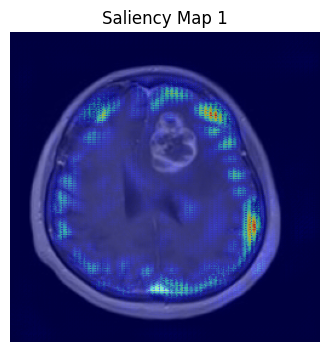

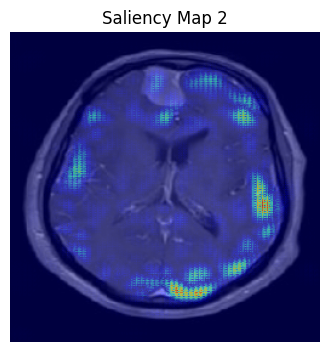

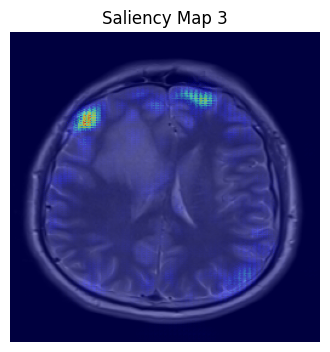

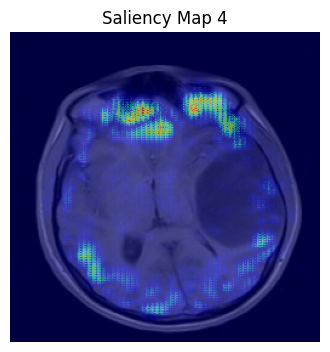

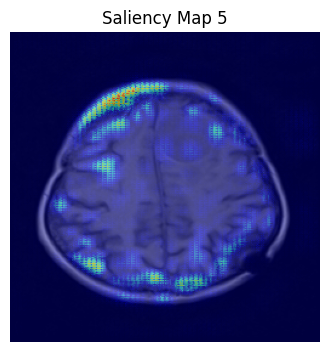

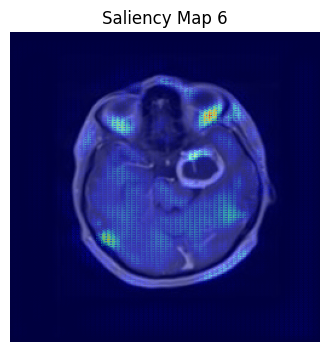

Saliency maps generated and saved to /kaggle/working/cyclegan_outputs/xai


In [21]:
# --- PHASE 1: Generate and Display all 6 Saliency Maps ---
print("--- PHASE 1: Saliency Maps ---")
try:
    netG_A2B.eval(); netD_B.eval()
    for i, mr_p in enumerate(selected):
        pil_img = dcm_to_pil(mr_p)
        sal, img_vis = compute_saliency(netG_A2B, netD_B, pil_img, transform)
        
        plt.figure(figsize=(4, 6)); plt.imshow(img_vis, cmap='gray'); plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.title(f'Saliency Map {i+1}'); plt.axis('off'); plt.savefig(os.path.join(xai_folder, f'saliency_{i:03d}.png')); plt.show(); plt.close()
        
    print(f'Saliency maps generated and saved to {xai_folder}')
except Exception as e:
    print(f"Saliency visualization failed: {e}")


--- PHASE 2: Grad-CAM Overlays ---


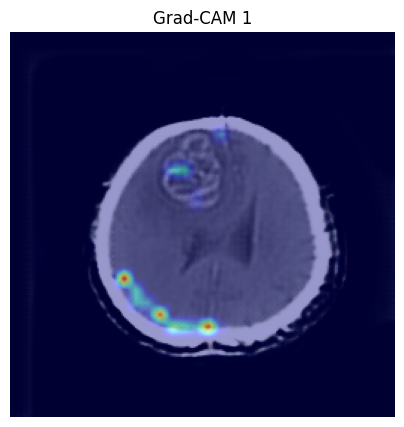

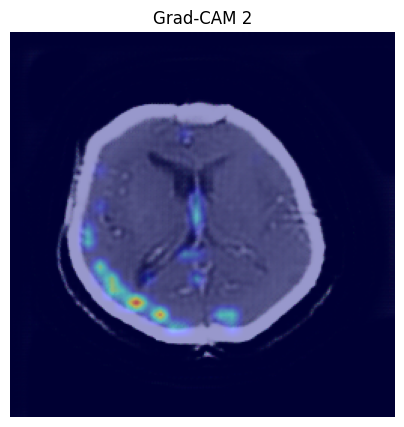

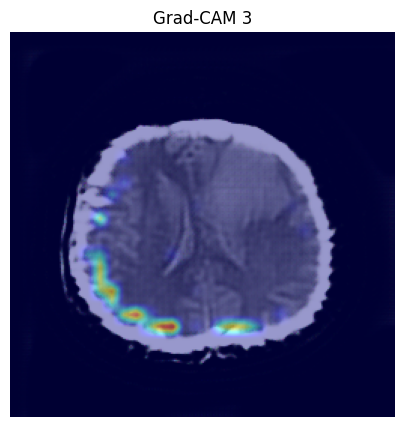

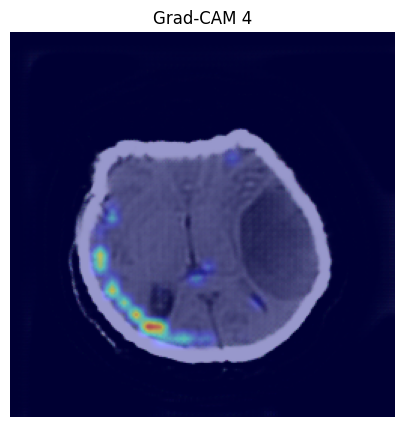

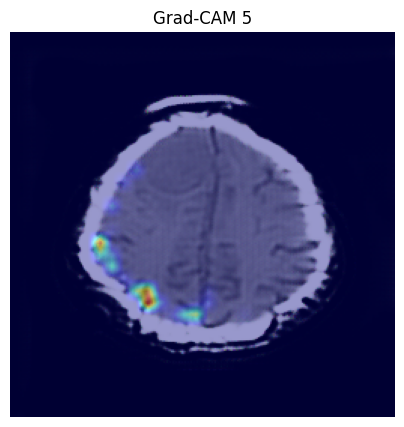

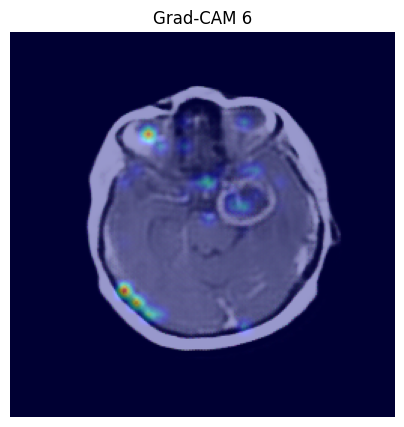

Grad-CAM maps generated and saved to /kaggle/working/cyclegan_outputs/xai_gradcam


In [22]:
# --- PHASE 2: Generate and Display all 6 Grad-CAM Overlays ---
print("\n--- PHASE 2: Grad-CAM Overlays ---")
try:
    netG_A2B.eval(); netD_B.eval()
    gradcam = GradCAM(netD_B, target_layer='model.7')
    
    for i, mr_p in enumerate(selected):
        pil_img = dcm_to_pil(mr_p)
        sample_A = transform(pil_img).unsqueeze(0).to(device)
        
        with torch.no_grad(): fake_translated = netG_A2B(sample_A)
        cam_map = gradcam(fake_translated)
        
        # Overlay and display the Grad-CAM result
        overlay_heatmap_and_show(fake_translated, cam_map, os.path.join(OUT_DIR, "xai_gradcam", f"gradcam_fake_{i+1}.png"), title=f"Grad-CAM {i+1}")
        
    gradcam.remove_hooks()
    print(f'Grad-CAM maps generated and saved to {os.path.join(OUT_DIR, "xai_gradcam")}')
except Exception as e:
    print(f"Grad-CAM visualization failed: {e}")

In [37]:
def visualize_feature_maps_heatmap(netG_A2B, real_A, device, num_samples=3, layer_index=10,
                                   save_dir='feature_maps', top_k=4, overlay=True):
    """
    Visualize top-k feature maps as a combined heatmap overlay on the input image.
    Works well for deep layers where individual maps are low-resolution and unclear.
    """
    os.makedirs(save_dir, exist_ok=True)
    activation = {}

    # Hook to capture activations
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    layer = netG_A2B.model[layer_index]
    hook_handle = layer.register_forward_hook(get_activation(f'layer_{layer_index}'))

    with torch.no_grad():
        for i in range(min(num_samples, real_A.size(0))):
            img = real_A[i].unsqueeze(0).to(device)
            _ = netG_A2B(img)
            fmap = activation[f'layer_{layer_index}'].cpu().squeeze(0)  # (C,H,W)

            # Compute top-k active channels
            act_strength = fmap.view(fmap.shape[0], -1).abs().mean(dim=1)
            top_indices = torch.topk(act_strength, min(top_k, fmap.shape[0])).indices

            # Combine top-k maps
            combined = fmap[top_indices].sum(dim=0).numpy()
            # Normalize
            combined = (combined - combined.min()) / (combined.max() - combined.min() + 1e-8)

            # Resize to input resolution using bilinear interpolation
            H, W = img.shape[2], img.shape[3]
            combined_resized = cv2.resize(combined, (W, H), interpolation=cv2.INTER_LINEAR)

            # Prepare input image for display
            img_disp = img[0].cpu().permute(1, 2, 0).numpy()
            img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min() + 1e-8)

            # Plot
            plt.figure(figsize=(6,6))
            if overlay:
                plt.imshow(img_disp)
                plt.imshow(combined_resized, cmap='viridis', alpha=0.5)
                plt.title(f"Sample {i+1} - Top-{top_k} Feature Maps Overlay (Layer {layer_index})")
            else:
                plt.imshow(combined_resized, cmap='viridis')
                plt.title(f"Sample {i+1} - Combined Top-{top_k} Feature Maps (Layer {layer_index})")
            plt.axis('off')

            save_path = os.path.join(save_dir, f"sample_{i+1}_top{top_k}_heatmap_layer_{layer_index}.png")
            plt.savefig(save_path)
            plt.show()
            plt.close()

    hook_handle.remove()
    print(f"Feature map heatmaps saved in: {save_dir}")


--- PHASE 3: Feature Maps (with Input Context) ---


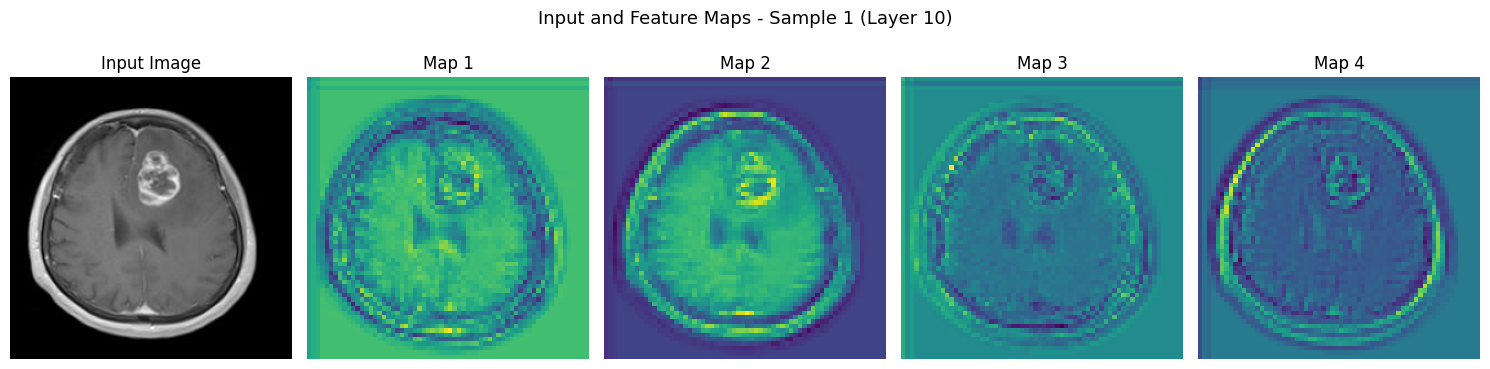

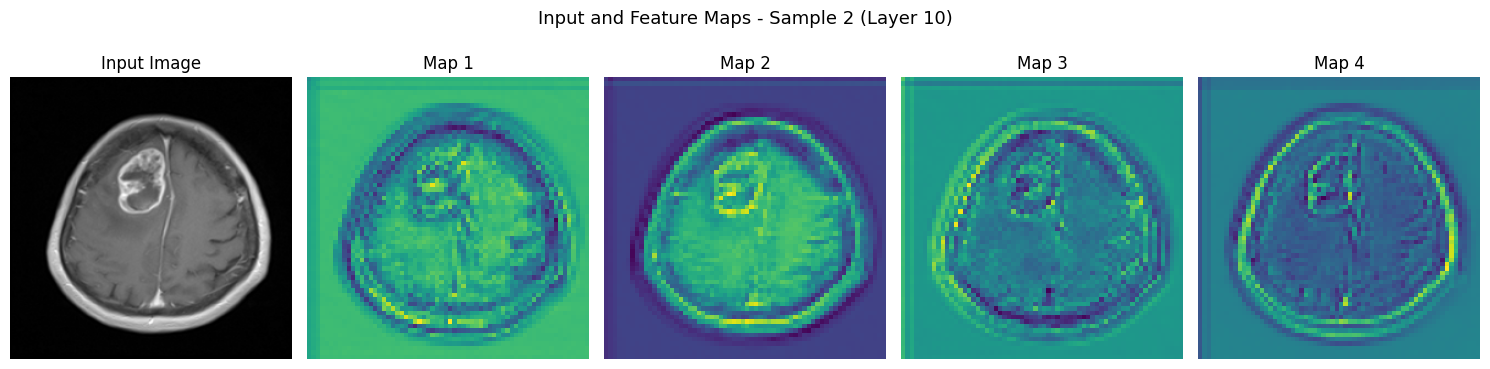

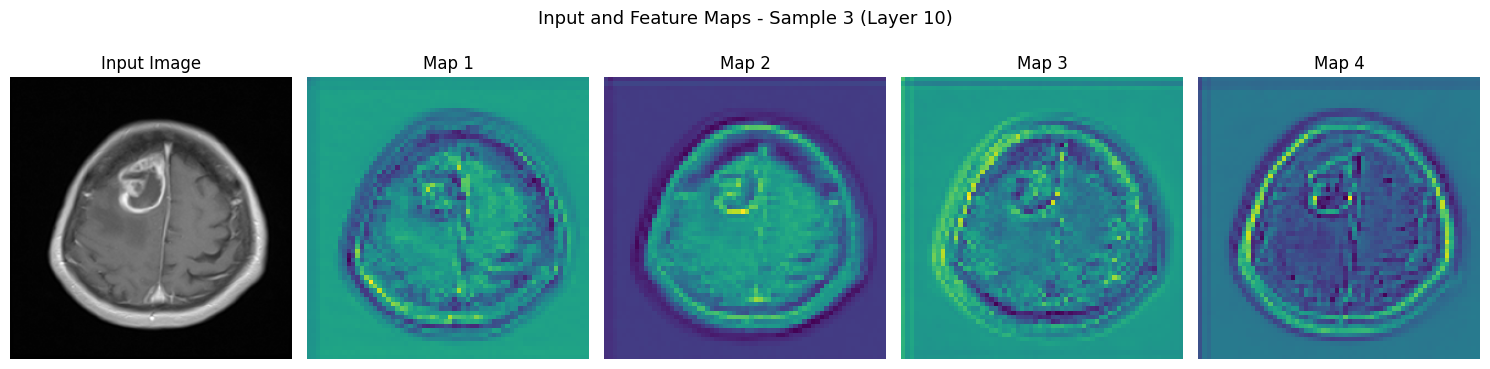

Feature maps (layer 10) saved in: /kaggle/working/cyclegan_outputs/xai_featuremaps


In [38]:
# Use the existing execution logic (no changes needed here, as the fix is within the function)
print("\n--- PHASE 3: Feature Maps (with Input Context) ---")
try:
    # Get a sample batch for visualization
    dataloader_val=DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,pin_memory=True, drop_last=True)
    real_A_sample = next(iter(dataloader_val))["A"]
    
    # This call now executes the side-by-side visualization
    visualize_feature_maps(netG_A2B, real_A_sample, device, num_samples=3, save_dir=os.path.join(OUT_DIR, "xai_featuremaps"))
except Exception as e:
    print(f"Feature Map visualization failed: {e}")

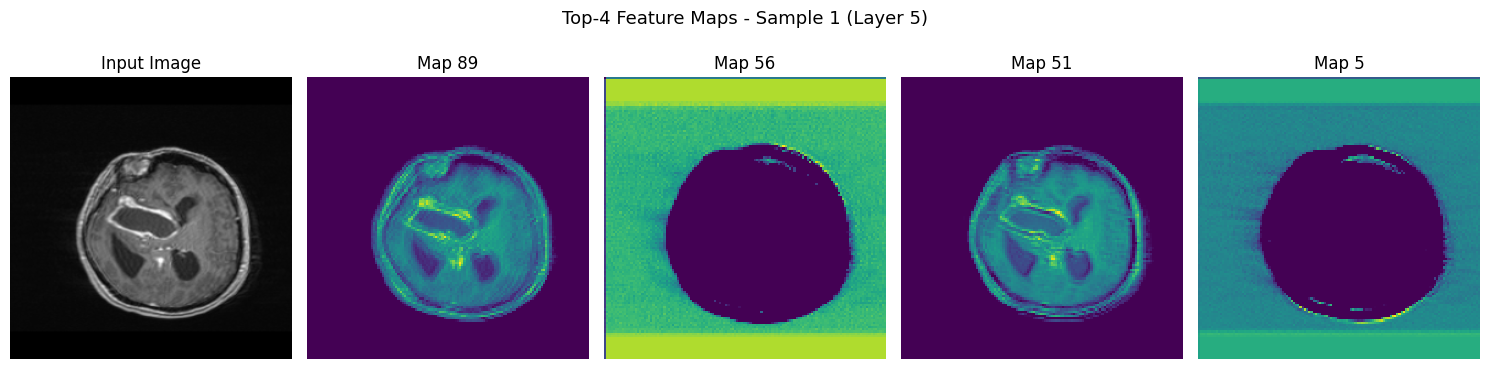

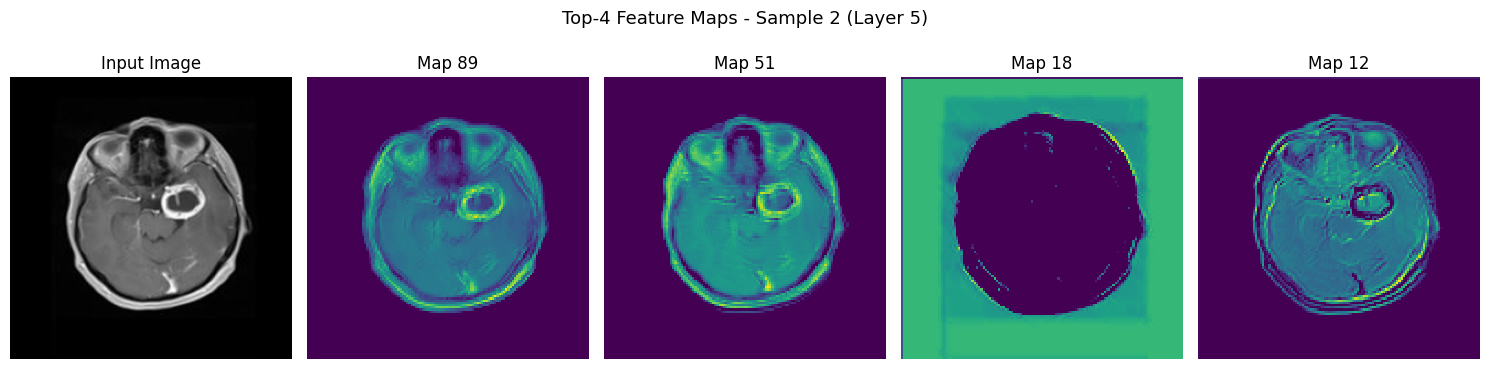

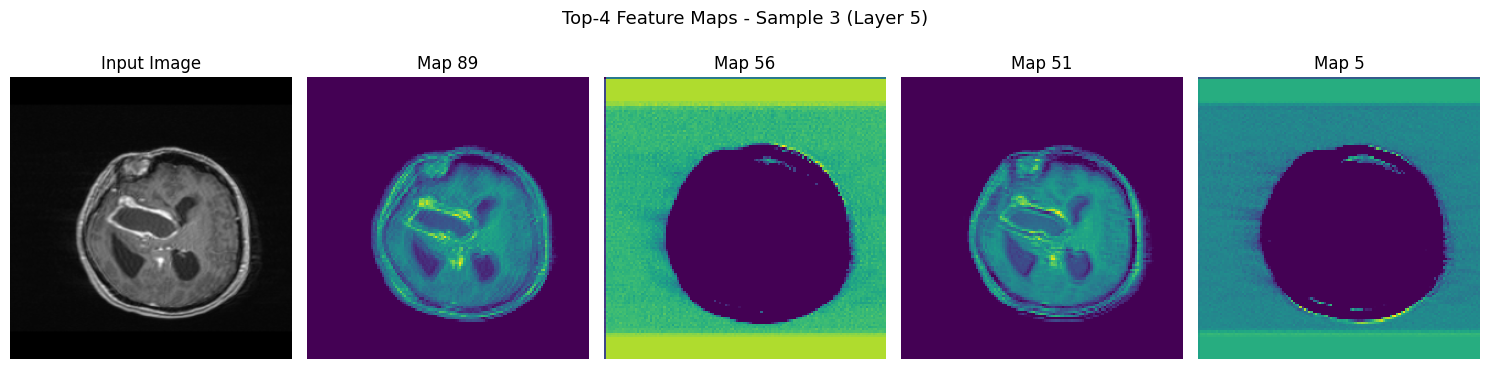

Feature maps (layer 5) saved in: feature_maps


In [42]:
def visualize_feature_maps_cycleGAN(netG_A2B, real_A, device, num_samples=3, layer_index=10, save_dir='feature_maps'):
    """
    Visualize intermediate feature maps for a CycleGAN generator (ResnetGenerator)
    along with the input image. Produces crisp, normalized feature maps.
    """
    os.makedirs(save_dir, exist_ok=True)
    activation = {}

    # Hook to capture the target layer activations
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    layer = netG_A2B.model[layer_index]
    hook_handle = layer.register_forward_hook(get_activation(f'layer_{layer_index}'))

    with torch.no_grad():
        # Make sure we loop over exactly num_samples images
        for i in range(num_samples):
            img = real_A[i % real_A.size(0)].unsqueeze(0).to(device)  # repeat if batch < num_samples
            _ = netG_A2B(img)  # forward pass triggers hook
            fmap = activation[f'layer_{layer_index}'].cpu().squeeze(0)  # (C,H,W)

            # Choose top 4 most activated channels for clarity
            act_strength = fmap.view(fmap.shape[0], -1).abs().mean(dim=1)
            top_indices = torch.topk(act_strength, min(4, fmap.shape[0])).indices

            # Convert input image for display
            img_disp = img[0].cpu().permute(1, 2, 0).numpy()
            img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min() + 1e-8)

            # Plot input + feature maps
            n_show = len(top_indices)
            fig, axes = plt.subplots(1, n_show + 1, figsize=(3*(n_show+1), 4))
            if n_show == 1: axes = [axes[0], axes[1]]  # handle single channel

            fig.suptitle(f"Top-{n_show} Feature Maps - Sample {i+1} (Layer {layer_index})", fontsize=13)

            # Show input image
            axes[0].imshow(img_disp)
            axes[0].set_title("Input Image")
            axes[0].axis('off')

            # Show top feature maps
            for j, idx in enumerate(top_indices):
                f = fmap[idx].numpy()
                # Normalize each map individually
                f = (f - f.min()) / (f.max() - f.min() + 1e-8)
                axes[j + 1].imshow(f, cmap='viridis', interpolation='nearest')
                axes[j + 1].set_title(f"Map {idx.item()+1}")
                axes[j + 1].axis('off')

            plt.tight_layout()
            save_path = os.path.join(save_dir, f"sample_{i+1}_layer_{layer_index}.png")
            fig.savefig(save_path)
            plt.show()
            plt.close(fig)

    hook_handle.remove()
    print(f"Feature maps (layer {layer_index}) saved in: {save_dir}") 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_feature_maps_cycleGAN(netG_A2B, real_A, device, num_samples=3, layer_index=5)